In [8]:
#Libraries
import torch
import torch.nn as nn
import random
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import os
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import json  # for saving lists as strings
import math
from timm import create_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score,f1_score, precision_recall_fscore_support
import time
from tqdm import tqdm

Utility Class and Dataloader

In [10]:
class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 2
    batch_size = 32
    num_epochs = 10
    learning_rate = 1e-4
    image_size = 224
    num_workers = 4
    pth_path = "/kaggle/input/hybrid_model/pytorch/default/1/hybrid_model.pth"

1. Swin BackBone Pretrained

In [11]:
class SwinBackbone(nn.Module):
    def __init__(self, model_name='swin_base_patch4_window7_224', pretrained=True, pth_path=None):
        super().__init__()
        self.backbone = create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='')
        self.feature_dim = self.backbone.num_features

        if pth_path:
            #print(f"Loading pretrained weights from {pth_path}")
            state_dict = torch.load(pth_path, map_location=Config.device)
            if 'model' in state_dict:
                state_dict = state_dict['model']
            self.load_state_dict(state_dict, strict=False)
            #print("Pretrained weights, Backbone loaded successfully.")

    def forward(self, x, return_tokens=True):
        features = self.backbone.forward_features(x)  # [B, H, W, C]
        #print("Inside SwinBackbone forward()")
        #print("Swin backbone raw output shape:", features.shape)
        B, H, W, C = features.shape
        features = features.reshape(B, H * W, C)  # No permute needed
        #print("Swin backbone reshaped tokens shape:", features.shape)
        if return_tokens:
            return features
        return features.permute(0, 2, 1).reshape(B, C, H, W)



2. EfficientNet Feature Branch

In [12]:
class EfficientNetBranch(nn.Module):
    def __init__(self, model_name='efficientnet_b0'):
        super().__init__()
        self.model = create_model(model_name, pretrained=True, features_only=True)
        self.out_channels = self.model.feature_info[-1]['num_chs']

    def forward(self, x):
        feat =self.model(x)[-1]  # [B, C, H, W]
        B, C, H, W = feat.shape
        return feat.flatten(2).transpose(1, 2)  # [B, N, C]


3. Croos Attention Fusion Module

In [13]:
class CrossAttentionFusion(nn.Module):
    def __init__(self, dim_swin, dim_eff, hidden_dim=512, num_heads=4):
        super().__init__()
        self.query_proj = nn.Linear(dim_swin, hidden_dim)
        self.key_proj = nn.Linear(dim_eff, hidden_dim)
        self.value_proj = nn.Linear(dim_eff, hidden_dim)
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads=num_heads, batch_first=True)
        self.output_proj = nn.Linear(hidden_dim, dim_swin)

    def forward(self, swin_tokens, eff_tokens):
       
        if swin_tokens.dim() == 4:
            swin_tokens = swin_tokens.flatten(2).transpose(1, 2)  # [B, N, C]
        if eff_tokens.dim() == 4:
            eff_tokens = eff_tokens.flatten(2).transpose(1, 2)    # [B, N, C]

        Q = self.query_proj(swin_tokens)
        K = self.key_proj(eff_tokens)
        V = self.value_proj(eff_tokens)
        fused, _ = self.attn(Q, K, V)
        
        return self.output_proj(fused)

4. Full Model

In [14]:
class DeepfakeDetector(nn.Module):
    def __init__(self, swin_pth=None, num_classes=2):
        super().__init__()
        self.swin = SwinBackbone(pth_path=swin_pth)
        self.efficient = EfficientNetBranch()
        
        # Print feature dims for debugging
       # print(f"Swin feature dim: {self.swin.feature_dim}")
       # print(f"EfficientNet out channels: {self.efficient.out_channels}")
        
        self.fusion = CrossAttentionFusion(dim_swin=self.swin.feature_dim,
                                           dim_eff=self.efficient.out_channels)
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(self.swin.feature_dim),
            nn.Linear(self.swin.feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Use your SwinBackbone's forward method, not directly calling its backbone
        swin_tokens = self.swin(x, return_tokens=True)  # Should be [B, N, C]
        #print("Swin tokens:", swin_tokens.shape)        # Must be 3D tensor [32, N, 1024]

        eff_tokens = self.efficient(x)                   # [B, N_eff, 320]
        #print("EfficientNet tokens:", eff_tokens.shape)

        fused = self.fusion(swin_tokens, eff_tokens)
        #print("Fused tokens:", fused.shape)

        pooled = fused.mean(dim=1)
        #print("Pooled features:", pooled.shape)

        out = self.classifier(pooled)
        #print("Classifier output:", out.shape)
        return out


5. Dataset Dataloader

In [15]:

def train_data_transform(data_fraction, batch_size, shuffle=True, num_workers=4, pin_memory=True):
    assert 0 < data_fraction <= 1, "data_fraction must be between 0 and 1"
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),            
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),            
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    dataset_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train"
    full_train_dataset = ImageFolder(dataset_path, transform=transform)

    # Set seed for reproducibility
    random.seed(42)

    num_train_data = int(len(full_train_dataset) * data_fraction)
    train_indices = random.sample(range(len(full_train_dataset)), num_train_data)

    train_dataset = Subset(full_train_dataset, train_indices)
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    return train_dataloader

In [16]:
def val_data_transform(data_fraction, batch_size, shuffle=False, num_workers=4, pin_memory=True):
    # Common ImageNet normalization mean and std

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Manually define the transform for Swin using the same ImageNet normalization
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),            
        transforms.Normalize(mean=mean, std=std)
    ])

    full_valid_dataset = ImageFolder("/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid", transform=transform)

    num_valid_data = int(len(full_valid_dataset) * data_fraction)
    random.seed(42)
    valid_indices = random.sample(range(len(full_valid_dataset)), num_valid_data)
    valid_dataset = torch.utils.data.Subset(full_valid_dataset, valid_indices)

    val_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return val_dataloader

In [17]:
def test_data_transform(data_fraction, batch_size, shuffle=False, num_workers=4, pin_memory=True):
    # Common ImageNet normalization mean and std           
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

        # Manually define the transform for Swin using the same ImageNet normalization
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    
    full_test_dataset = ImageFolder("/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test", transform=transform)

    num_test_data = int(len(full_test_dataset) * data_fraction)
    random.seed(42)
    test_indices = random.sample(range(len(full_test_dataset)), num_test_data)

    test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)

    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return test_dataloader

6. Training Utilities

In [18]:
def train_one_epoch(epoch, model, train_dataloader, criterion, optimizer, scheduler, device):
   
    model.train()
    running_loss = 0.0
    train_acc = 0
    total = 0
    y_true, y_pred = [], []

    loop = tqdm(enumerate(train_dataloader), total = len(train_dataloader), desc=f"Epoch [{epoch+1}/{Config.num_epochs}]")
    for batch_idx, (images, labels) in loop:
        total += labels.size(0)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = outputs.argmax(dim=1)
        train_acc += (predicted == labels).sum().item()
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = train_acc / total

    return epoch_loss, epoch_acc, y_true, y_pred

In [19]:
def validate(model, val_dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    val_acc = 0
    total = 0
    y_true_val, y_pred_val = [], []

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            predicted = outputs.argmax(dim=1)
            val_acc += (predicted == labels).sum().item()

            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(val_dataloader.dataset)
    epoch_acc = accuracy_score(y_true_val, y_pred_val)

    return epoch_loss, epoch_acc, y_true_val, y_pred_val

7. Main Training Script

In [20]:
def train_model(data_fraction=1.0):
    device = Config.device
    print(f"Using device: {device}")

        # Dataset info for logging
    num_train_data = int(100000 * data_fraction)
    num_valid_data = int(20000 * data_fraction)
    print(f"Training samples: {num_train_data}")
    print(f"Validation samples: {num_valid_data}")

    train_dataloader = train_data_transform(data_fraction=data_fraction, batch_size=Config.batch_size)
    val_dataloader = val_data_transform(data_fraction=data_fraction, batch_size=Config.batch_size)

    model = DeepfakeDetector(swin_pth=Config.pth_path).to(device)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.num_epochs)

    history = []
    best_f1= 0.0
    val_f1= 0.0
    trigger_times = 0
    patience = 4
    train_y= []
    train_pred = []
    valid_y = []
    val_pred = []

    print("="*10 +"Starting training"+ "="*10)

    for epoch in range(Config.num_epochs):
        print(f"Epoch {epoch+1}/{Config.num_epochs}")
        print('-' * 50)
        start = time.time()
        train_loss, train_acc, y_true_train, y_pred_train =  train_one_epoch(epoch, model, train_dataloader, criterion, optimizer, scheduler, device)
        val_loss, val_acc, y_true_val, y_pred_val = validate(model, val_dataloader, criterion, device)
        scheduler.step()


        _, _, train_f1, _ = precision_recall_fscore_support(y_true_train, y_pred_train, average='macro', zero_division=0)
        _, _, val_f1, _ = precision_recall_fscore_support(y_true_val, y_pred_val, average='macro', zero_division=0) 

        print(f"Epoch [{epoch+1}/{Config.num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f},Val F1:{val_f1:.4f} - "
              f"Time: {time.time() - start:.2f}s")
       
        train_y.append(y_true_train)
        train_pred.append(y_pred_train)
        valid_y.append(y_true_val)
        val_pred.append(y_pred_val) 
        
        history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'train_f1': train_f1,
            'val_f1': val_f1,
        })
       
        # Save the best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            trigger_times = 0
            torch.save(model.state_dict(), 'hybrid_model.pth')
            print(f"✅ Best model saved with best F1 Score: {best_f1:.4f}")
        else:
            trigger_times += 1
            print(f"❌ No improvement in validation f1. Patience: {trigger_times}/{patience}")
            if trigger_times >= patience:
                print("⛔ Early stopping triggered.")
                break

    # ✅ Save complete metrics + predictions in one CSV
    df_hist = pd.DataFrame(history)
    df_hist.to_csv("full_training_metrics.csv", index=False)

    print("📁 Training history saved.")
    return train_y, train_pred, valid_y, val_pred

## Calling from Main

In [13]:
train_prediction = []
if __name__ == "__main__":
    y_train, y_train_pred,val_y, val_pred = train_model(data_fraction=1)

Using device: cuda
Training samples: 100000
Validation samples: 20000


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

==========Starting training==========
Epoch 1/10
--------------------------------------------------


Epoch [1/10]: 100%|██████████| 3125/3125 [38:01<00:00,  1.37it/s, loss=0.00323] 


Epoch [1/10] - Train Loss: 0.0904, Train Acc: 0.9669 - Val Loss: 0.0180, Val Acc: 0.9941,Val F1:0.9941 - Time: 2428.16s
✅ Best model saved with best F1 Score: 0.9941
Epoch 2/10
--------------------------------------------------


Epoch [2/10]: 100%|██████████| 3125/3125 [37:59<00:00,  1.37it/s, loss=0.0195]  


Epoch [2/10] - Train Loss: 0.0384, Train Acc: 0.9867 - Val Loss: 0.0213, Val Acc: 0.9921,Val F1:0.9921 - Time: 2426.15s
❌ No improvement in validation f1. Patience: 1/4
Epoch 3/10
--------------------------------------------------


Epoch [3/10]: 100%|██████████| 3125/3125 [37:59<00:00,  1.37it/s, loss=0.0286]  


Epoch [3/10] - Train Loss: 0.0241, Train Acc: 0.9917 - Val Loss: 0.0183, Val Acc: 0.9948,Val F1:0.9948 - Time: 2426.63s
✅ Best model saved with best F1 Score: 0.9948
Epoch 4/10
--------------------------------------------------


Epoch [4/10]: 100%|██████████| 3125/3125 [38:00<00:00,  1.37it/s, loss=0.0178]  


Epoch [4/10] - Train Loss: 0.0185, Train Acc: 0.9939 - Val Loss: 0.0174, Val Acc: 0.9928,Val F1:0.9928 - Time: 2426.85s
❌ No improvement in validation f1. Patience: 1/4
Epoch 5/10
--------------------------------------------------


Epoch [5/10]: 100%|██████████| 3125/3125 [37:59<00:00,  1.37it/s, loss=0.000238]


Epoch [5/10] - Train Loss: 0.0122, Train Acc: 0.9959 - Val Loss: 0.0109, Val Acc: 0.9959,Val F1:0.9958 - Time: 2426.21s
✅ Best model saved with best F1 Score: 0.9958
Epoch 6/10
--------------------------------------------------


Epoch [6/10]: 100%|██████████| 3125/3125 [37:59<00:00,  1.37it/s, loss=4.11e-5] 


Epoch [6/10] - Train Loss: 0.0081, Train Acc: 0.9973 - Val Loss: 0.0105, Val Acc: 0.9963,Val F1:0.9963 - Time: 2426.38s
✅ Best model saved with best F1 Score: 0.9963
Epoch 7/10
--------------------------------------------------


Epoch [7/10]: 100%|██████████| 3125/3125 [38:00<00:00,  1.37it/s, loss=6.82e-7] 


Epoch [7/10] - Train Loss: 0.0057, Train Acc: 0.9981 - Val Loss: 0.0205, Val Acc: 0.9929,Val F1:0.9929 - Time: 2426.83s
❌ No improvement in validation f1. Patience: 1/4
Epoch 8/10
--------------------------------------------------


Epoch [8/10]: 100%|██████████| 3125/3125 [37:59<00:00,  1.37it/s, loss=0.000574]


Epoch [8/10] - Train Loss: 0.0034, Train Acc: 0.9989 - Val Loss: 0.0052, Val Acc: 0.9982,Val F1:0.9982 - Time: 2426.64s
✅ Best model saved with best F1 Score: 0.9982
Epoch 9/10
--------------------------------------------------


Epoch [9/10]: 100%|██████████| 3125/3125 [37:59<00:00,  1.37it/s, loss=2.53e-7] 


Epoch [9/10] - Train Loss: 0.0021, Train Acc: 0.9992 - Val Loss: 0.0060, Val Acc: 0.9981,Val F1:0.9981 - Time: 2426.26s
❌ No improvement in validation f1. Patience: 1/4
Epoch 10/10
--------------------------------------------------


Epoch [10/10]: 100%|██████████| 3125/3125 [37:59<00:00,  1.37it/s, loss=0.00213] 


Epoch [10/10] - Train Loss: 0.0024, Train Acc: 0.9993 - Val Loss: 0.0065, Val Acc: 0.9978,Val F1:0.9978 - Time: 2426.14s
❌ No improvement in validation f1. Patience: 2/4
📁 Training history saved.


Inference

In [21]:

# Load model class (same as training)
class InferenceModel(DeepfakeDetector):
    def __init__(self, model_path='/kaggle/input/hybrid_model/pytorch/default/1/hybrid_model.pth'):
        super().__init__(swin_pth=None)
        self.load_state_dict(torch.load(model_path, map_location='cpu'))

In [22]:

# Load model
model = InferenceModel('/kaggle/input/hybrid_model/pytorch/default/1/hybrid_model.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

InferenceModel(
  (swin): SwinBackbone(
    (backbone): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (layers): Sequential(
        (0): SwinTransformerStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_path1): Identity()
              (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (mlp)

Testing 

In [23]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm

def test_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    y_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    # Save results
    df_results = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'prob_real': [p[0] for p in y_probs],
        'prob_fake': [p[1] for p in y_probs]
    })
    df_results.to_csv("test_results.csv", index=False)
    print("✅ Test results saved to test_results.csv")

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    print(f"\n🔍 Test Accuracy: {acc:.4f}\n")

    print("📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig("confusion_matrix_real_fake.png", dpi=500)
    plt.show()

    # ROC AUC Curve
    y_true_binary = [1 if y == 1 else 0 for y in y_true]
    y_score = [p[1] for p in y_probs]  # Prob of class "Fake"

    auc_score = roc_auc_score(y_true_binary, y_score)
    print(f"🧠 AUC-ROC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(y_true_binary, y_score)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("roc_curve_real_fake.png", dpi=500)
    plt.show()

    return df_results


Testing: 100%|██████████| 625/625 [04:55<00:00,  2.11it/s]


✅ Test results saved to test_results.csv

🔍 Test Accuracy: 0.9980

📋 Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00     10000
        Fake       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



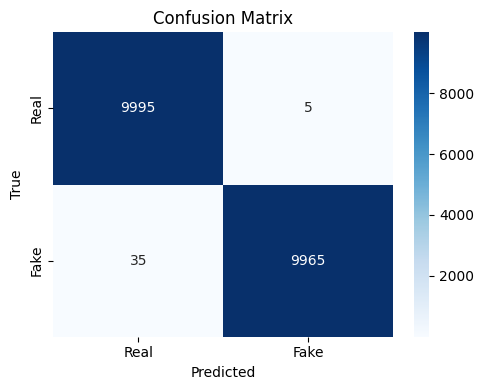

🧠 AUC-ROC Score: 1.0000


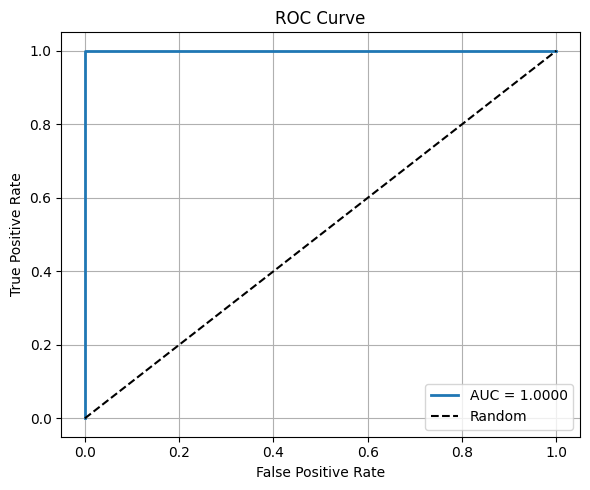

In [24]:
test_dataloader = test_data_transform(data_fraction=1, batch_size=Config.batch_size)

# Run test
df_test = test_model(model, test_dataloader, Config.device)

In [27]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, save_path="training_curves.png"):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, 'g-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'g-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=500)
    plt.show()


✅ Accuracy plot saved at: plots_output/accuracy_plot.png


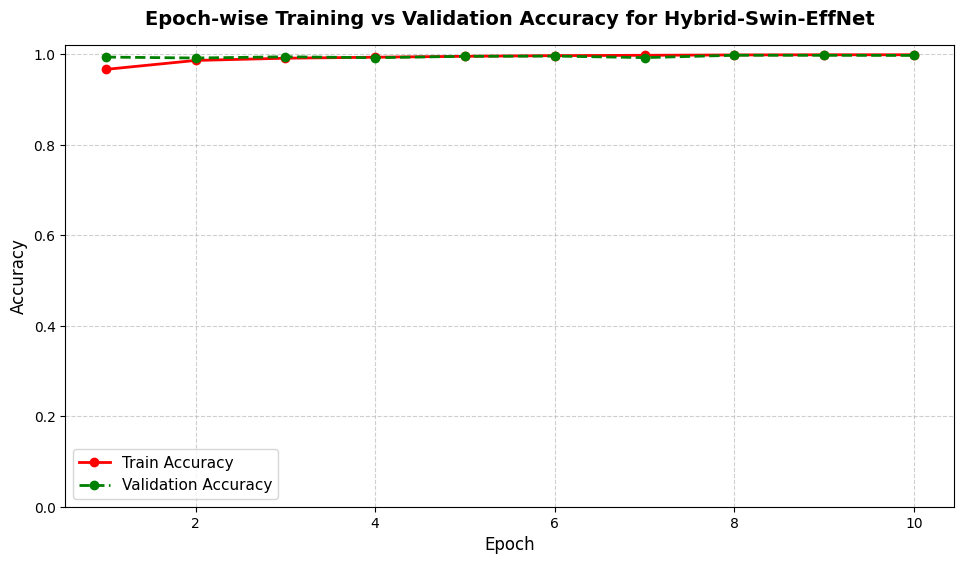

✅ Loss plot saved at: plots_output/loss_plot.png


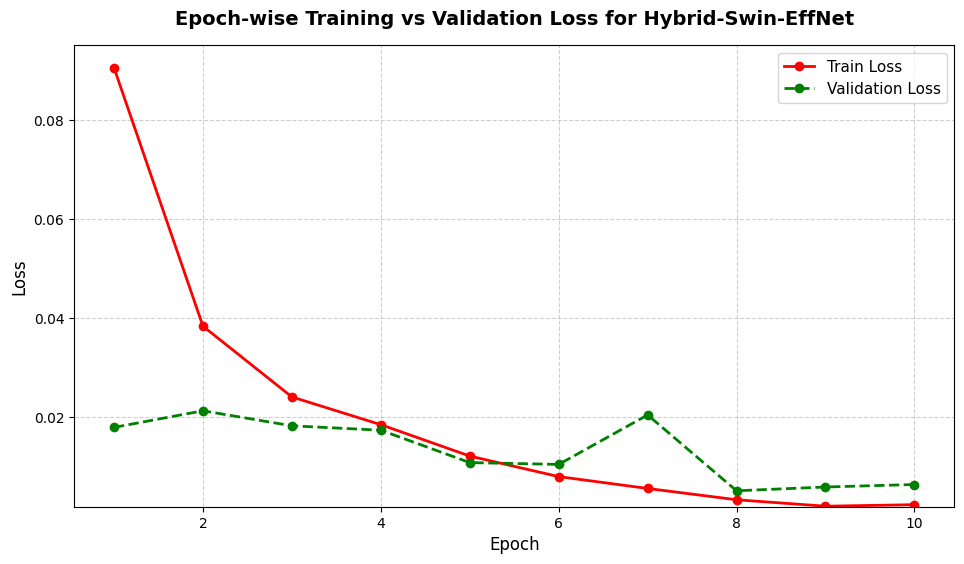

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# Load and Clean CSV
# ============================
csv_path = "/kaggle/input/train/full_training_metrics.csv"  # This is what your train_model() saved
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()  # Remove spaces just in case

# Generate epoch column if needed
if 'epoch' not in df.columns:
    df['epoch'] = range(1, len(df) + 1)

# ============================
# Function: Plot Accuracy Graph
# ============================
def plot_accuracy(df, save_dir=None, model_name="Hybrid-Swin-EffNet"):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(df['epoch'], df['train_acc'], marker='o', color='red', label='Train Accuracy', linewidth=2)
    ax.plot(df['epoch'], df['val_acc'], marker='o', linestyle='--', color='green', label='Validation Accuracy', linewidth=2)

    ax.set_title(f'Epoch-wise Training vs Validation Accuracy for {model_name}', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_ylim(0.0, 1.02)
    ax.legend(fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(pad=2.0)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        acc_path = os.path.join(save_dir, 'accuracy_plot.png')
        plt.savefig(acc_path, dpi=500)
        print(f"✅ Accuracy plot saved at: {acc_path}")
    plt.show()

# ============================
# Function: Plot Loss Graph
# ============================
def plot_loss(df, save_dir=None, model_name="Hybrid-Swin-EffNet"):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(df['epoch'], df['train_loss'], marker='o', color='red', label='Train Loss', linewidth=2)
    ax.plot(df['epoch'], df['val_loss'], marker='o', linestyle='--', color='green', label='Validation Loss', linewidth=2)

    ax.set_title(f'Epoch-wise Training vs Validation Loss for {model_name}', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)

    min_loss = min(df['train_loss'].min(), df['val_loss'].min())
    max_loss = max(df['train_loss'].max(), df['val_loss'].max())
    ax.set_ylim(min_loss * 0.95, max_loss * 1.05)

    ax.legend(fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(pad=2.0)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        loss_path = os.path.join(save_dir, 'loss_plot.png')
        plt.savefig(loss_path, dpi=500)
        print(f"✅ Loss plot saved at: {loss_path}")
    plt.show()

# ============================
# Generate Plots
# ============================
plot_accuracy(df, save_dir="plots_output", model_name="Hybrid-Swin-EffNet")
plot_loss(df, save_dir="plots_output", model_name="Hybrid-Swin-EffNet")


# GradCAM VISUALIZATION

In [25]:
!pip install grad-cam


In [30]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch

# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load model ===
model = InferenceModel().to(device)
model.eval()



InferenceModel(
  (swin): SwinBackbone(
    (backbone): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (layers): Sequential(
        (0): SwinTransformerStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_path1): Identity()
              (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (mlp)

In [31]:
# === Select target layer from EfficientNet path ===
target_layer = model.efficient.model.blocks[-1][0].conv_dw




In [32]:
# === Load & preprocess image ===
img_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/02TPLQKRQB.jpg"
rgb_image = np.array(Image.open(img_path).convert("RGB").resize((224, 224))).astype(np.float32) / 255.0
input_tensor = preprocess_image(rgb_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)



In [33]:
# === Create GradCAM object (no use_cuda/device=) ===
cam = GradCAM(model=model, target_layers=[target_layer])

# === Generate CAM ===
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(1)])[0]



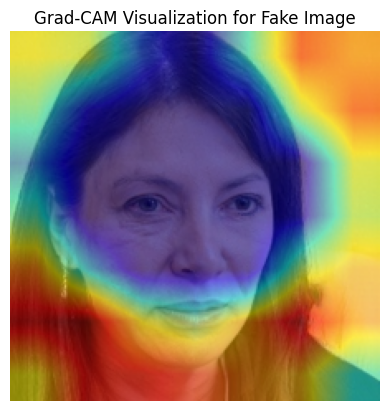

In [34]:
# === Visualize ===
visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.axis('off')
plt.title("Grad-CAM Visualization for Fake Image")
plt.savefig("gradcam_output.png", dpi=500)
plt.show()

In [35]:
# === Load & preprocess image ===
img_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00016.jpg"
rgb_image = np.array(Image.open(img_path).convert("RGB").resize((224, 224))).astype(np.float32) / 255.0
input_tensor = preprocess_image(rgb_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

In [36]:
# === Create GradCAM object (no use_cuda/device=) ===
cam = GradCAM(model=model, target_layers=[target_layer])

# === Generate CAM ===
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(1)])[0]

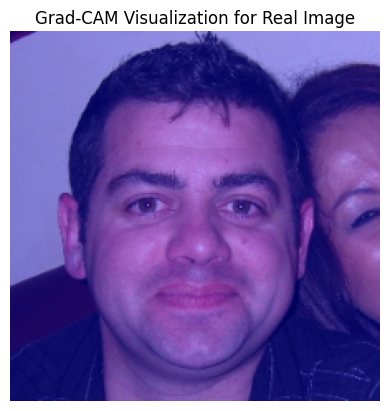

In [37]:
# === Visualize ===
visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.axis('off')
plt.title("Grad-CAM Visualization for Real Image")
plt.savefig("gradcam_output.png", dpi=500)
plt.show()

In [38]:
# === Load & preprocess image ===
img_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00F8LKY6JC.jpg"
rgb_image = np.array(Image.open(img_path).convert("RGB").resize((224, 224))).astype(np.float32) / 255.0
input_tensor = preprocess_image(rgb_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

In [39]:
# === Create GradCAM object (no use_cuda/device=) ===
cam = GradCAM(model=model, target_layers=[target_layer])

# === Generate CAM ===
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(1)])[0]

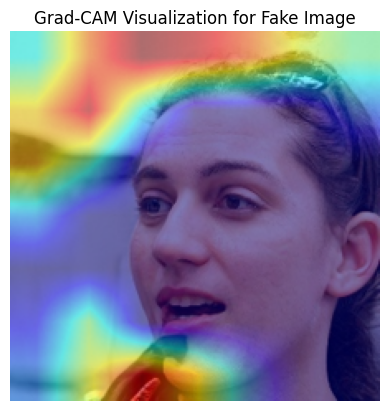

In [40]:
# === Visualize ===
visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.axis('off')
plt.title("Grad-CAM Visualization for Fake Image")
plt.savefig("gradcam_output.png", dpi=500)
plt.show()

In [ ]:
import os
import random
from glob import glob
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image


fake_image_folder = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake"  # ✅ Replace if needed
image_paths = glob(os.path.join(fake_image_folder, "*.jpg"))  # or *.jpg, *.jpeg

selected_images = random.sample(image_paths, 5)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InferenceModel().to(device)
model.eval()
target_layer = model.efficient.model.blocks[-1][0].conv_dw 
cam = GradCAM(model=model, target_layers=[target_layer])
label_map = {0: "Real", 1: "Fake"}




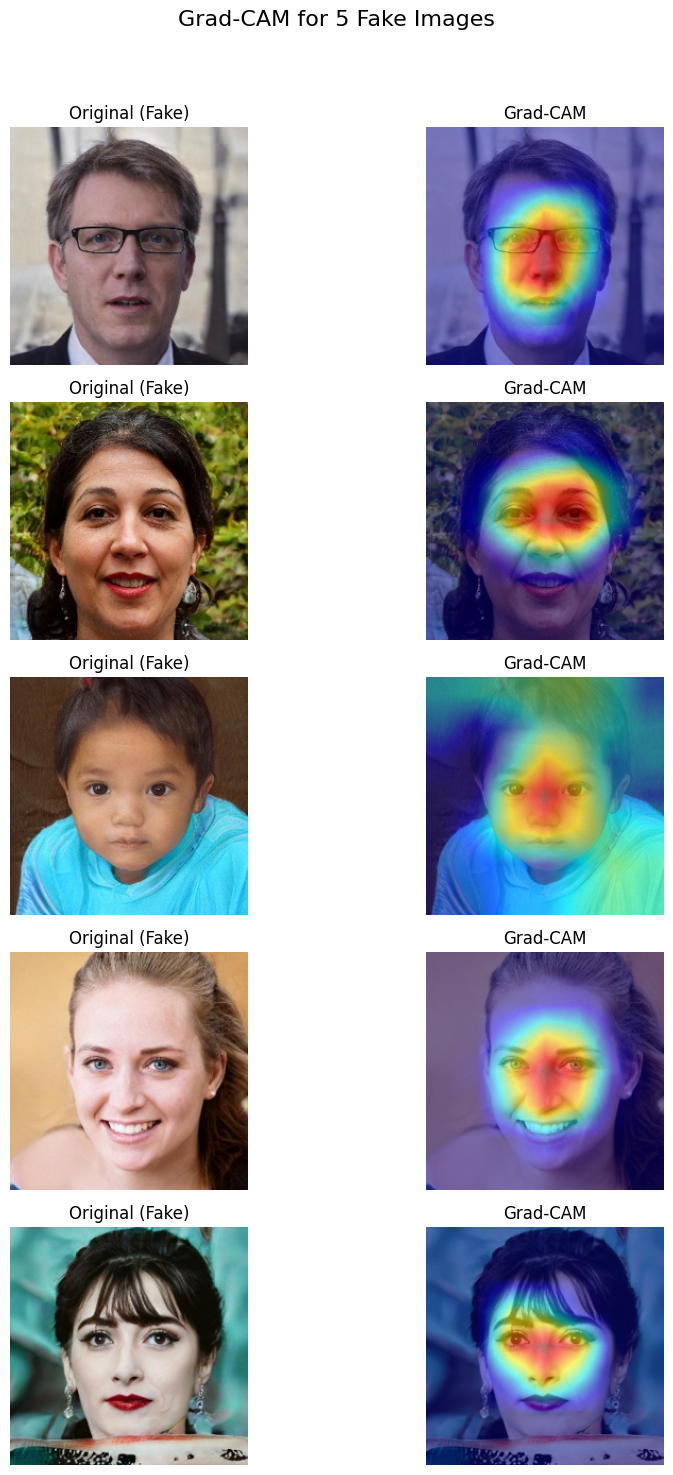

In [ ]:


fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))
fig.suptitle("Grad-CAM for 5 Fake Images", fontsize=16)

for i, img_path in enumerate(selected_images):

    rgb_image = np.array(Image.open(img_path).convert("RGB").resize((224, 224))).astype(np.float32) / 255.0
    input_tensor = preprocess_image(rgb_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

    

 
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0]
    visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    axs[i, 0].imshow(rgb_image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"Original (Fake)")

    axs[i, 1].imshow(visualization)
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f"Grad-CAM")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("gradcam_5_fake_rowwise.png", dpi=500)
plt.show()

In [ ]:
import os
import random
from glob import glob
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image


fake_image_folder = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real"  # ✅ Replace if needed
image_paths = glob(os.path.join(fake_image_folder, "*.jpg"))  # or *.jpg, *.jpeg


selected_images = random.sample(image_paths, 5)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InferenceModel().to(device)
model.eval()
target_layer = model.efficient.model.blocks[-1][0].conv_dw  # 🧠 EfficientNet Conv2D
cam = GradCAM(model=model, target_layers=[target_layer])
label_map = {0: "Real", 1: "Fake"}

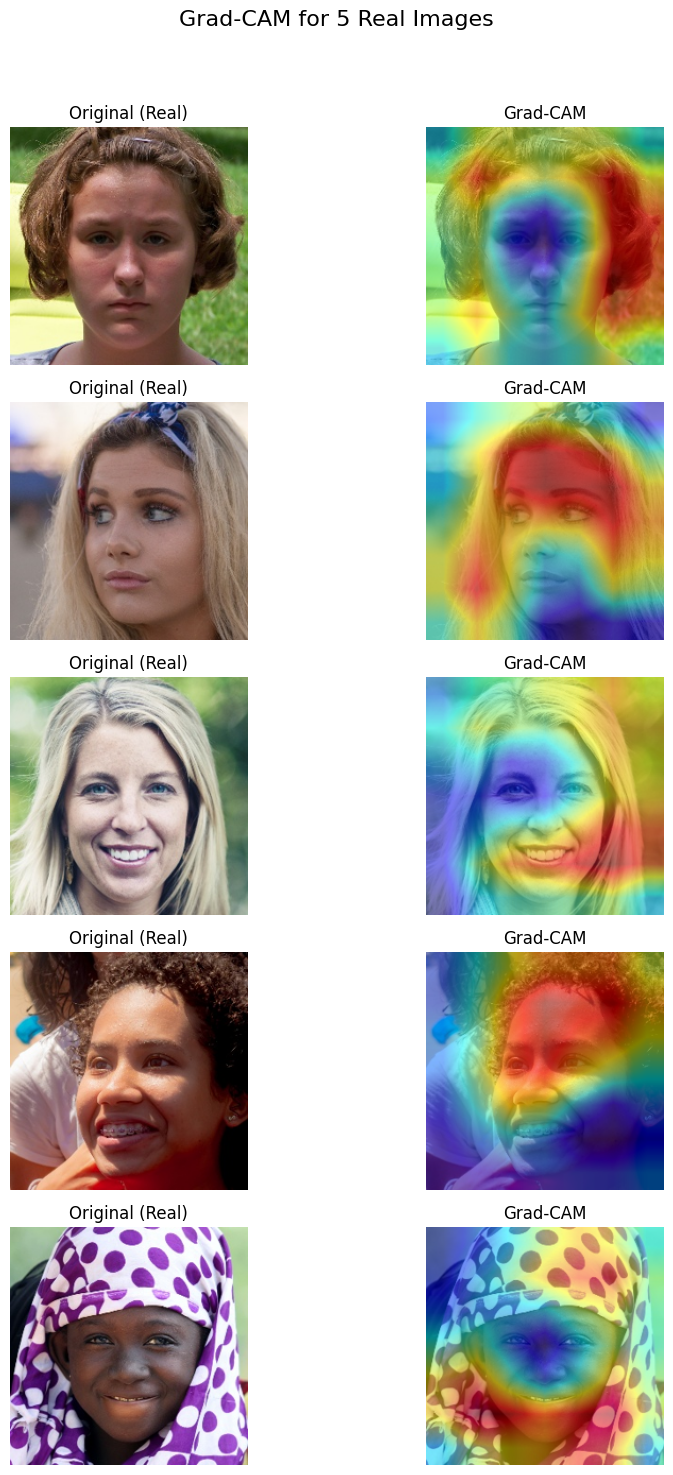

In [ ]:

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))
fig.suptitle("Grad-CAM for 5 Real Images", fontsize=16)

for i, img_path in enumerate(selected_images):
   
    rgb_image = np.array(Image.open(img_path).convert("RGB").resize((224, 224))).astype(np.float32) / 255.0
    input_tensor = preprocess_image(rgb_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

    

    
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])[0]
    visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    axs[i, 0].imshow(rgb_image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"Original (Real)")

    axs[i, 1].imshow(visualization)
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f"Grad-CAM")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("gradcam_5_Real_rowwise.png", dpi=500)
plt.show()

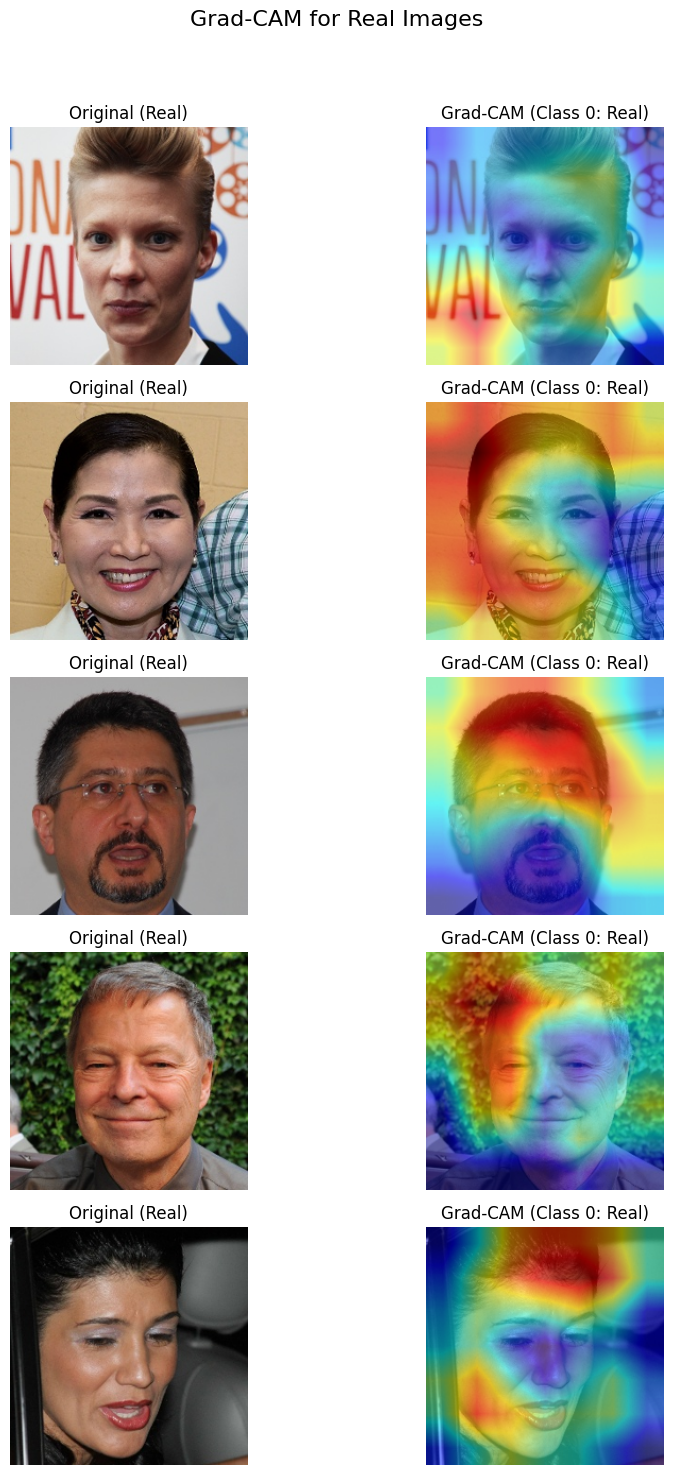

In [ ]:
import os
import random
from glob import glob
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image


real_image_folder = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real"
image_paths = glob(os.path.join(real_image_folder, "*.jpg"))  # or *.png if needed


num_images = min(5, len(image_paths))
if num_images == 0:
    raise ValueError("❌ No images found in the specified folder.")
selected_images = random.sample(image_paths, num_images)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InferenceModel().to(device)
model.eval()
target_layer = model.efficient.model.blocks[-1][0].conv_dw
cam = GradCAM(model=model, target_layers=[target_layer])

fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, num_images * 3))
fig.suptitle("Grad-CAM for Real Images", fontsize=16)

for i, img_path in enumerate(selected_images):

    rgb_image = np.array(Image.open(img_path).convert("RGB").resize((224, 224))).astype(np.float32) / 255.0
    input_tensor = preprocess_image(rgb_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)

  
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(0)])[0]
    visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

  
    axs[i, 0].imshow(rgb_image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"Original (Real)")

    axs[i, 1].imshow(visualization)
    axs[i, 1].axis('off')
    axs[i, 1].set_title("Grad-CAM (Class 0: Real)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("gradcam_real_rowwise.png", dpi=500)
plt.show()


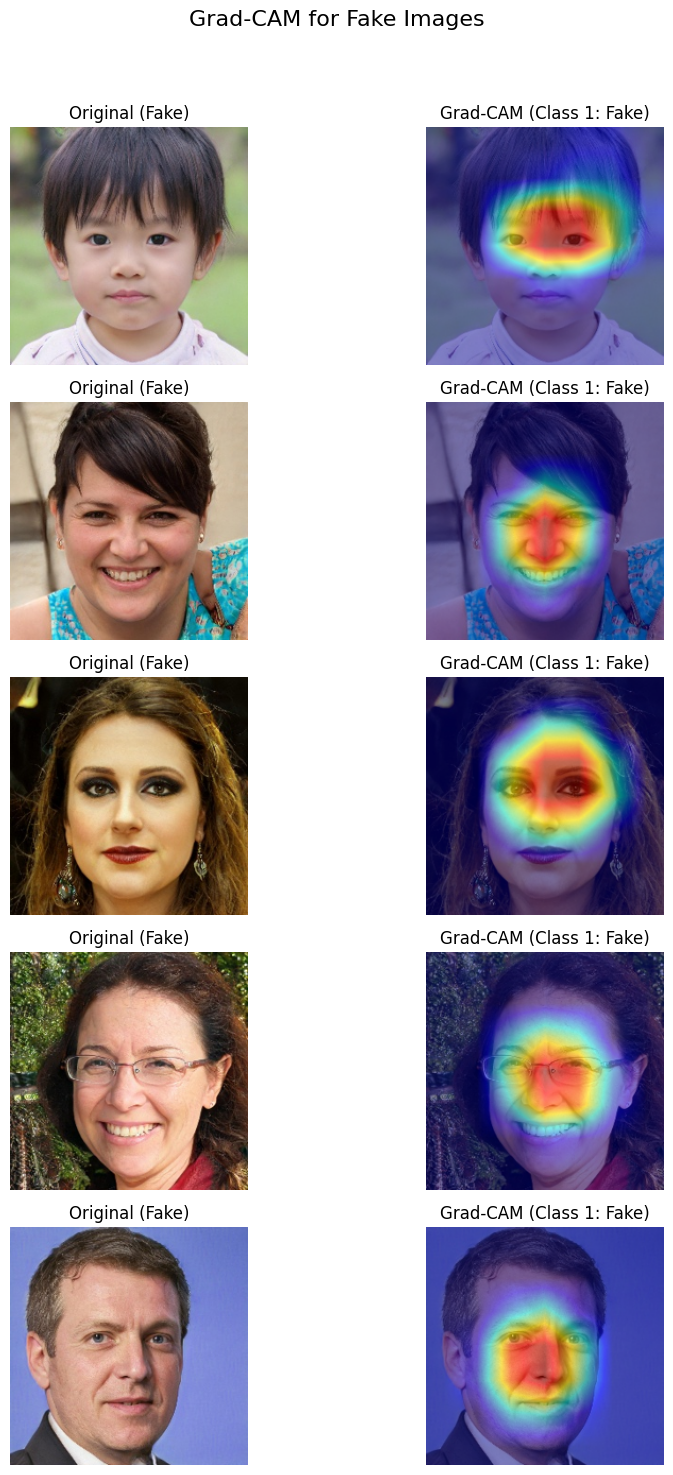

In [ ]:
import os
import random
from glob import glob
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image


real_image_folder = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake"
image_paths = glob(os.path.join(real_image_folder, "*.jpg"))  # or *.png if needed

num_images = min(5, len(image_paths))
if num_images == 0:
    raise ValueError("❌ No images found in the specified folder.")
selected_images = random.sample(image_paths, num_images)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InferenceModel().to(device)
model.eval()
target_layer = model.efficient.model.blocks[-1][0].conv_dw
cam = GradCAM(model=model, target_layers=[target_layer])


fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, num_images * 3))
fig.suptitle("Grad-CAM for Fake Images", fontsize=16)

for i, img_path in enumerate(selected_images):

    rgb_image = np.array(Image.open(img_path).convert("RGB").resize((224, 224))).astype(np.float32) / 255.0
    input_tensor = preprocess_image(rgb_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)


    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(0)])[0]
    visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)


    axs[i, 0].imshow(rgb_image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"Original (Fake)")

    axs[i, 1].imshow(visualization)
    axs[i, 1].axis('off')
    axs[i, 1].set_title("Grad-CAM (Class 1: Fake)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("gradcam_fake_rowwise.png", dpi=500)
plt.show()


In [ ]:
import shap
import os
import random
from glob import glob
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import transforms


real_image_folder = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real"
image_paths = glob(os.path.join(real_image_folder, "*.jpg"))
num_images = min(5, len(image_paths))
selected_images = random.sample(image_paths, num_images)






In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InferenceModel().to(device)
model.eval()

# === Define transform for SHAP ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts to [0, 1]
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# === Preprocess selected images ===
input_tensors = []
original_images = []
for path in selected_images:
    img = Image.open(path).convert("RGB")
    original_images.append(np.array(img.resize((224, 224))) / 255.0)
    tensor = transform(img).unsqueeze(0).to(device)
    input_tensors.append(tensor)